In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

os.chdir(  "/Users/etmu9498/research/code/scripts")
import make_plots

In [4]:
crl_path = "/Users/etmu9498/research/data/CRL_data/2021"
crl_list = make_plots.load_crl( crl_path)
crl_name = crl_list[ 17]

os.chdir( crl_path)
data = xr.open_dataset( crl_name)
data

crl data files:
0) P3_20210811H1_200000-224759.cdf
1) P3_20210812H1_095513-125927.cdf
2) P3_20210812H2_212248-235510.cdf
3) P3_20210813H1_091801-113558.cdf
4) P3_20210816H1_085245-123459.cdf
5) P3_20210816H1_090000-102359.cdf
6) P3_20210817H1_094204-132058.cdf
7) P3_20210818H1_211425-244159.cdf
8) P3_20210819H1_213003-244159.cdf
9) P3_20210820H1_212402-245958.cdf
10) P3_20210821H2_213903-225658.cdf
11) P3_20210821H2_213903-262058.cdf
12) P3_20210827H1_203112-275220.cdf
13) P3_20210828H1_200115-221321.cdf
14) P3_20210829H1_171201-223719.cdf
15) P3_20210925H1_211201-243558.cdf
16) P3_20210926H1_220900-255058.cdf
17) P3_20210927H1_213003-253558.cdf
18) P3_20210929H2_211201-261159.cdf


<xarray.Dataset>
Dimensions:             (Time: 7322, layers: 594)
Dimensions without coordinates: Time, layers
Data variables:
    ProductionDateTime  |S24 ...
    VersionID           int16 ...
    Lon                 (Time) float32 ...
    Lat                 (Time) float32 ...
    H                   (layers) float32 ...
    time                (Time) float32 ...
    LSR                 (Time, layers) float32 ...
    WVMR                (Time, layers) float32 ...
    T                   (Time, layers) float32 ...
    P_ch1               (Time, layers) float32 ...
Attributes:
    global_att:    This file is generated with our Compact Raman lidar measur...
    global_att1:   The data for each flight is mapped to the same height bin ...
    global_att2:  For Question about this product, contact Zhien Wang, 
    global_att3:   University of Colorado, Boulder at zhien.wang@colorado.edu

In [7]:
# crop data around eye to make things run faster
i1 =  0 # 5300
i2 =  6000 # 5600
lon = data.Lon[ i1: i2]
lat = data.Lat[ i1: i2]
power = data.P_ch1[ i1: i2]
time = data.time[ i1: i2]

H = data.H
H_index = range( len( H))
# a list of height indices, to be used later
H_index_matrix = np.repeat(np.array( H_index)[None, :], len( time), axis=0)


# print( np.size( H_index_matrix, 0))
# print( np.size( H_index_matrix, 1))
# print( np.size( power, 0))
# print( np.size( power, 1))


# cut off top 8 values to get rid of error from flight level data
power = power[:, 8:]
H_index_matrix = H_index_matrix[:, 8:]

power = 10 * np.log10( power)

# cycle through four different power cutoffs
cutoff_list = [ -22, -25, -30, -35]  # dBz
colors = ['k', 'b', 'g', 'y']
labels = [ '-22 dBz', '-25 dBz', '-30 dBz', '-35 dBz']


C:\Users\etmu9498\Anaconda3\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
C:\Users\etmu9498\Anaconda3\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


CPU times: total: 1min 34s
Wall time: 1min 34s


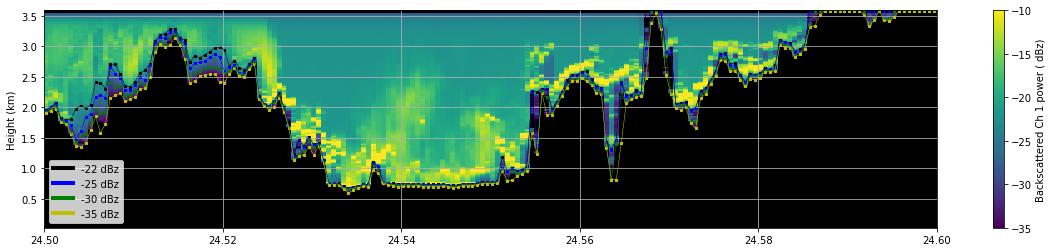

In [9]:
%%time

# create figure before for loop
# plt.figure( figsize=(14.9, 4))
# plt.grid('on')
# plt.xlim( [24.5, 24.6])
# plt.ylabel( 'Height (km)')

plt.figure( figsize=(20, 4))
make_plots.plot_power_ch1( crl_path, crl_name, i1, i2, 'time')
plt.xlim( [24.5, 24.6])

for i in range( len( cutoff_list)):

    # range of power values after these two steps: between -.6 and cutoff dBz 
    temp = power.where( power.values > cutoff_list[i])
    
    # if there is a nan value, turn it into a zero.
    power_threshold = np.where( np.isnan( temp) , 0, H_index_matrix)
           
    '''
    with np.printoptions(threshold=np.inf):
        print( power_threshold[0, :])
    power_col = power_threshold[ 0, :]
    power_col = power_col[ power_col > 0 ]
    print( power_col)
    '''
    
    power_index = np.empty( len( time), dtype=int)
    for column_index in range( len( time)):
        power_col = power_threshold[ column_index, :]
        power_col = power_col[ power_col > 0]
        
        # check for empty list
        if np.size( power_col) == 0:
            power_index[ column_index] = 0
        else:
            power_index[ column_index] = power_col[ -1]
            
    # use np.count_nonzero() to sum up all of the nonzero values!
    # power_index = np.count_nonzero( power_threshold, 1)
    power_threshold2 = np.where( np.isnan( temp) , 0, 1)
    power_index2 = np.sum( power_threshold2, 1)
    
    labels2 = ["no sum 20", 'no sum 25', 'no sum 30', 'no sum 40']
    
    plt.scatter( time, - H[ power_index], c= colors[i], s=8, marker='s')
    plt.plot( time, - H[power_index], c= colors[i], linewidth=.5, label= labels[i])
    # plt.plot( time, - H[power_index2], linewidth=.5, label= labels2[i])
    
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(4.0)
    
os.chdir( "/Users/etmu9498/research/figures/cloud-tops/test/")
plt.savefig( "tops-and-crl-test.png"  )
